In [168]:
# XGboost: hyperparameters
# scale_pos_weight: unbalance dataset . value = sum(negative cases)/ sum(postive case)
# eval_metric: Use AUC for false postive, error for accuracy etc

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

In [169]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer


from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC


from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.pipeline import 
from imblearn.pipeline import Pipeline



from imblearn.over_sampling import SMOTE


import re
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

Next, we load our datasets and the data dictionary file.

The train.csv file contains both dependent and independent features, while the test.csv contains only the independent variables.

So, for model selection, I will create our own train/test dataset from the train.csv and use the model to predict the solution using the features in unseen test.csv data for submission.

In [170]:
# data = pd.read_csv("train.csv")
# unseen = pd.read_csv("test.csv")
# sample = pd.read_csv("sample.csv")
# data_dict = pd.read_csv("data_dictionary.csv")

# print(data.shape)
# print(unseen.shape)
# print(sample.shape)
# print(data_dict.shape)

1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [171]:
data =pd.read_csv('./kaggle/input/train.csv')
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [172]:
#__________________________________________________________________#InitialCheck

In [173]:
#initial check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [174]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


In [175]:
# create original Copy of data
data_org  = data.copy()

In [148]:
ids = ['id','circle_id']
recharge_date = [i for i in list(data.columns) if re.search('date_of_last_rech',i)] 
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
total_incoming_minutes = [i for i in list(data.columns) if re.search('total.+ic.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]
average_revenue_per_user = [i for i in list(data.columns) if re.search('arpu_[6,7,8]',i)]
max_amounts = [i for i in list(data.columns) if re.search('max_rech_amt_',i)]
total_amounts_data = [i for i in list(data.columns) if re.search('total_rech_data_[6,7,8]',i)]
max_amounts_data = [i for i in list(data.columns) if re.search('max_rech_data_[6,7,8]',i)]
average_amount_data = [i for i in list(data.columns) if re.search('av_rech_amt_data_[6,7,8]',i)]
night_pck_user = [i for i in list(data.columns) if re.search('night_pck_user_[6,7,8]',i)]
fb_user = [i for i in list(data.columns) if re.search('fb_user_[6,7,8]',i)]
vbc = [ 'jun_vbc_3g', 'jul_vbc_3g','aug_vbc_3g', ]
date_of_last_recharge = [i for i in list(data.columns) if re.search('date.*',i)]

std_outgoing_minutes = [i for i in list(data.columns) if re.search('std_og_mou.+',i)]
std_incoming_minutes = [i for i in list(data.columns) if re.search('std_ic_mou.+',i)]

isd_outgoing_minutes = [i for i in list(data.columns) if re.search('isd_og_mou.+',i)]
isd_incoming_minutes = [i for i in list(data.columns) if re.search('isd_ic_mou.+',i)]

loc_outgoing_minutes = [i for i in list(data.columns) if re.search('loc_og_mou.+',i)]
loc_incoming_minutes = [i for i in list(data.columns) if re.search('loc_ic_mou.+',i)]

roam_outgoing_minutes = [i for i in list(data.columns) if re.search('roam_og_mou.+',i)]
roam_incoming_minutes = [i for i in list(data.columns) if re.search('roam_ic_mou.+',i)]


spl_outgoing_minutes = [i for i in list(data.columns) if re.search('spl_og_mou.+',i)]
spl_incoming_minutes = [i for i in list(data.columns) if re.search('spl_ic_mou.+',i)]

other_outgoing_minutes = [i for i in list(data.columns) if re.search('og_others.+',i)]
other_incoming_minutes = [i for i in list(data.columns) if re.search('ic_others.+',i)]

count_of_recharge_3g = [i for i in list(data.columns) if re.search('count_rech_3g+',i)]
count_of_recharge_2g = [i for i in list(data.columns) if re.search('count_rech_2g.+',i)]

total_recharge_number = [i for i in list(data.columns) if re.search('total_rech_num.+',i)]



#Storing them in a single flat list
variables1 = [*ids, 
             *recharge_date,
             *total_amounts, 
             *max_amounts,
             *total_outgoing_minutes, 
             *total_incoming_minutes,
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             *average_revenue_per_user,
             *total_amounts_data,
             *max_amounts_data,
             *average_amount_data,
             *night_pck_user,
             *fb_user,
             *vbc,
             *std_outgoing_minutes,
             *std_incoming_minutes,
             *isd_outgoing_minutes,
             *isd_incoming_minutes,
             *loc_outgoing_minutes,
             *loc_incoming_minutes,
             *roam_outgoing_minutes,
             *roam_incoming_minutes,
             *spl_outgoing_minutes,
             *spl_incoming_minutes,
             *other_outgoing_minutes,
             *other_incoming_minutes,
             *count_of_recharge_3g,
             *count_of_recharge_2g,
             *total_recharge_number,
             'churn_probability']

# data = data[variables].set_index('id')
len(variables1)

# Dropped the column like t2f, t2c, onnet, offnet etc instead using aggregate column

103

In [ ]:
da

In [182]:
recharge_date_columns = [
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
]

# List of date columns for data recharge
data_recharge_date_columns = [
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'
]

# Convert columns to datetime format
for col in recharge_date_columns + data_recharge_date_columns:
    data[col] = pd.to_datetime(data[col], format='%m/%d/%Y', errors='coerce')

# Get the last recharge date by taking the maximum date across specified columns
data['last_recharge_date'] = data[recharge_date_columns].max(axis=1)

# Get the last data recharge date by taking the maximum date across specified columns
data['last_data_recharge_date'] = data[data_recharge_date_columns].max(axis=1)

# Display the DataFrame with the new columns
print(data[['last_recharge_date', 'last_data_recharge_date']].head())

  last_recharge_date last_data_recharge_date
0         2014-08-24                     NaT
1         2014-08-26              2014-07-08
2         2014-08-24                     NaT
3         2014-08-25                     NaT
4         2014-08-30              2014-08-20


In [184]:
data[['last_recharge_date', 'last_data_recharge_date']].isna().mean()*100

last_recharge_date          0.092858
last_data_recharge_date    62.680895
dtype: float64

In [181]:
data[[
        'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
        'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
        'date_of_last_rech_data_8']].isna().mean()*100

last_date_of_month_6         0.000000
last_date_of_month_7         0.570008
last_date_of_month_8         1.047158
date_of_last_rech_6          1.572880
date_of_last_rech_7          1.762882
date_of_last_rech_8          3.515765
date_of_last_rech_data_6    74.902499
date_of_last_rech_data_7    74.478207
date_of_last_rech_data_8    73.689624
dtype: float64

In [178]:
object = data.select_dtypes(include='object').columns
len(object), object

(9,
 Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
        'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
        'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
        'date_of_last_rech_data_8'],
       dtype='object'))

In [ ]:
data.columns

In [177]:
set(data.columns) - set(variables1)

{'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2o_mou',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2o_mou',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_t2m_mou_6',
 'std_ic_t2m_mou_7',
 'std_ic_t2m_mou_8',
 'std

In [150]:
data = data[variables1]

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [151]:
unique_vals_ls_4 = []
for col in variables1:
    uv = data[col].nunique()
    if uv < 2:
        unique_vals_ls_4.append((col))
len(unique_vals_ls_4)

1

In [152]:
unique_vals_ls_4

['circle_id']

In [153]:
data = data.drop('circle_id', axis=1)

In [154]:
#---------------------------------------------------------------filter HighValue Customer


In [155]:
def filter_high_value_customer(data):
    data['AVG_amt_6_7'] = data[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1)
    data = data[data['AVG_amt_6_7'] > data['AVG_amt_6_7'].quantile(.5)]
    data = data.drop('AVG_amt_6_7', axis = 1)
    return data

data = filter_high_value_customer(data)

In [156]:
y = data.pop('churn_probability')
X = data
print(X.shape, y.shape)

(34979, 101) (34979,)


In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27983, 101), (6996, 101), (27983,), (6996,))

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

In [159]:
len(data.columns)

101

In [160]:
# missing data and Uniquer value

missing_per = data.isna().mean()*100
missing_per

id                           0.000000
date_of_last_rech_6          0.345922
date_of_last_rech_7          0.574630
date_of_last_rech_8          2.387147
date_of_last_rech_data_6    66.056777
                              ...    
count_rech_2g_7             65.399240
count_rech_2g_8             65.765173
total_rech_num_6             0.000000
total_rech_num_7             0.000000
total_rech_num_8             0.000000
Length: 101, dtype: float64

In [161]:
new_vars = missing_per[missing_per.le(40)].index
new_vars

Index(['id', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8',
       'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'arpu_6', 'arpu_7', 'arpu_8', 'jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g',
       'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'std_ic_mou_6',
       'std_ic_mou_7', 'std_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7',
       'isd_og_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_ic_mou_6',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7',
       'roam_og_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8'

In [162]:
data = data[new_vars]

In [163]:
len(new_vars)

71

In [164]:
X_train_filtered = X_train[new_vars]

In [165]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'std_og_mou_6',
       'std_og_mou_7', 'std_og_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
       'std_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'loc_og_mou_6',
       'loc_og_mou_7', 'loc_og_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'loc_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7',
       'spl_ic_mou_8', 'og_others_6', 'og_others_7', 'og_others_8',
       'ic_others_6', 'ic_others_7', 'ic_others_8'],
      dtype='object')

In [167]:
print(new_vars)

Index(['id', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8',
       'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'arpu_6', 'arpu_7', 'arpu_8', 'jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g',
       'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'std_ic_mou_6',
       'std_ic_mou_7', 'std_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7',
       'isd_og_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_ic_mou_6',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7',
       'roam_og_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8'

In [166]:
imp = KNNImputer(n_neighbors=10)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

ValueError: could not convert string to float: '6/29/2014'

# create new feature

In [1]:
def get_days_since_last_recharge(data):
    # Convert date columns to datetime
    for col in ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']:
        data[col] = pd.to_datetime(data[col], format='%m/%d/%Y')
    
    # Compute the most recent recharge date
    data['last_recharge_date'] = data[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max(axis=1)
    
    # Determine the maximum date across all rows
    max_date = data[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max().max()
    
    # Compute the days since the last recharge
    data['days_since_last_recharge'] = (max_date - data['last_recharge_date']).dt.days
    
    # Drop unnecessary columns
    data = data.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'last_recharge_date'], axis=1)
    
    return data



In [ ]:
def create_variance_cols(data, base_col, suffixes):

    # Ensure the suffixes list has exactly three elements
    if len(suffixes) != 3:
        raise ValueError("Suffixes list must contain exactly three elements.")
    
    # Construct column names and variance column name
    cols = [f'{base_col}_{suffix}' for suffix in suffixes]
    variance_col = f'{base_col}_variance'
    
    # Calculate variance
    data[variance_col] = data[cols].var(axis=1)
    
    return data

# data = create_variance_cols(data, 'total_rech_data', ['6', '7', '8'])

In [1238]:
def sum_columns(data, col1, col2, target_col, suffixes):

    
    # Construct column names and sum column names
    for suffix in suffixes:
        col1_name = f'{col1}_{suffix}'
        col2_name = f'{col2}_{suffix}'
        sum_col_name = f'{target_col}_{suffix}'
        
        # Calculate sum and add as new column
        data[sum_col_name] = data[col1_name] + data[col2_name]
    
    return data

In [1059]:
# variables

In [1060]:
# new_vars

In [1061]:
def create_pct_changes(data, base_col, suffixes):

    # Ensure the suffixes list has exactly three elements
    if len(suffixes) != 3:
        raise ValueError("Suffixes list must contain exactly three elements.")

    # Construct column names and percentage change column names
    col_1 = f'{base_col}_{suffixes[0]}'
    col_2 = f'{base_col}_{suffixes[1]}'
    col_3 = f'{base_col}_{suffixes[2]}'
    
    pct_change_1_2 = f'{base_col}_pct_change_{suffixes[0]}_{suffixes[1]}'
    pct_change_2_3 = f'{base_col}_pct_change_{suffixes[1]}_{suffixes[2]}'
    
    # Calculate percentage changes
    data[pct_change_1_2] = 100 * ((data[col_2] - data[col_1]) / (data[col_1] + 1e-5))
    data[pct_change_2_3] = 100 * ((data[col_3] - data[col_2]) / (data[col_2] + 1e-5))
    
    return data




In [1062]:
def create_ratio_cols(data, numerator_col, denominator_col, suffixes):
    
    # Ensure the suffixes list has exactly three elements
    if len(suffixes) != 3:
        raise ValueError("Suffixes list must contain exactly three elements.")

    # Construct column names and ratio column names
    col_num_1 = f'{numerator_col}_{suffixes[0]}'
    col_num_2 = f'{numerator_col}_{suffixes[1]}'
    col_num_3 = f'{numerator_col}_{suffixes[2]}'
    
    col_den_1 = f'{denominator_col}_{suffixes[0]}'
    col_den_2 = f'{denominator_col}_{suffixes[1]}'
    col_den_3 = f'{denominator_col}_{suffixes[2]}'
    
    ratio_1 = f'{numerator_col}_to_{denominator_col}_{suffixes[0]}'
    ratio_2 = f'{numerator_col}_to_{denominator_col}_{suffixes[1]}'
    ratio_3 = f'{numerator_col}_to_{denominator_col}_{suffixes[2]}'
    
    # Calculate ratios
    data[ratio_1] = data[col_num_1] / (data[col_den_1] + 1e-5)
    data[ratio_2] = data[col_num_2] / (data[col_den_2] + 1e-5)
    data[ratio_3] = data[col_num_3] / (data[col_den_3] + 1e-5)
    
    return data

# data = create_ratio_cols(data, 'total_mou', 'total_data_mb', ['6', '7', '8'])

In [1063]:
def create_variance_cols(data, base_col, suffixes):

    # Ensure the suffixes list has exactly three elements
    if len(suffixes) != 3:
        raise ValueError("Suffixes list must contain exactly three elements.")
    
    # Construct column names and variance column name
    cols = [f'{base_col}_{suffix}' for suffix in suffixes]
    variance_col = f'{base_col}_variance'
    
    # Calculate variance
    data[variance_col] = data[cols].var(axis=1)
    
    return data

# data = create_variance_cols(data, 'total_rech_data', ['6', '7', '8'])

In [ ]:
data = get_days_since_last_recharge(data)

In [ ]:
columns = [('std_ic_mou', 'std_og_mou', 'std_mou'), ('isd_ic_mou', 'isd_og_mou', 'isd_mou'), ('loc_ic_mou', 'loc_og_mou', 'loca_mou'),
          ('roam_ic_mou', 'roam_og_mou', 'roam_mou'), ('spl_ic_mou', 'spl_og_mou', 'spl_mou'), ('ic_others', 'og_others', 'others'),
            ('total_ic_mou', 'total_og_mou', 'total_mou'), ('vol_3g_mb', 'vol_2g_mb', 'total_data_mb')
          ]
for col1, col2, target_col in columns:
    # data = create_pct_changes(data, 'total_rech_amt', ['6', '7', '8'])
    data = sum_columns(data, col1, col2, target_col, ['6', '7', '8'])

In [1065]:
columns = ['total_rech_amt', 'max_rech_amt', 'total_mou', 'vol_2g_mb', 'vol_3g_mb', 'total_data_mb']
for col in columns:
    # data = create_pct_changes(data, 'total_rech_amt', ['6', '7', '8'])
    data = create_pct_changes(data, col, ['6', '7', '8'])


In [1066]:
columns = [('total_mou', 'total_data_mb'), ]
for num, denom in columns:
    # data = create_pct_changes(data, 'total_rech_amt', ['6', '7', '8'])
    # print(num, denom)
    data = create_ratio_cols(data, num, denom, ['6', '7', '8'])


In [1067]:
columns = ['total_rech_data','total_mou','total_rech_amt', 'total_data_mb']
for col in columns:
    # data = create_pct_changes(data, 'total_rech_amt', ['6', '7', '8'])
    # print(num, denom)
    data = create_variance_cols(data, col, ['6', '7', '8'])

In [1070]:
#  Id Column make it inde
data = data.set_index('id')

In [1071]:
len(data.columns)

98

In [1079]:
new_vars=data.columns

# missing data and Uniquer value

In [1085]:
# Unique value:  Drop columns which have only one unique value

In [1087]:
new_vars  = set(new_vars) - set(unique_vals_ls_4)
new_vars = list(new_vars)
len(new_vars)

72

In [1088]:
data = data[new_vars]

In [1089]:
# identify data type

In [1090]:
object = data.select_dtypes(include='object').columns
len(object), object

(0, Index([], dtype='object'))

In [1091]:
numerical = data.select_dtypes(include='number').columns
len(numerical), numerical

(72,
 Index(['loc_mou_7', 'std_mou_6', 'arpu_7', 'total_data_mb_7', 'max_rech_amt_6',
        'total_mou_variance', 'vol_3g_mb_6', 'total_mou_6',
        'total_mou_to_total_data_mb_7', 'aug_vbc_3g', 'max_rech_amt_8',
        'jun_vbc_3g', 'vol_3g_mb_7', 'offnet_mou_6', 'total_rech_amt_8',
        'total_mou_7', 'offnet_mou_7', 'churn_probability',
        'vol_2g_mb_pct_change_7_8', 'total_data_mb_pct_change_6_7', 'isd_mou_7',
        'total_rech_amt_pct_change_7_8', 'total_og_mou_7', 'isd_mou_6',
        'vol_2g_mb_7', 'spl_mou_8', 'std_mou_7', 'others_7', 'roam_mou_8',
        'total_ic_mou_6', 'roam_mou_7', 'vol_3g_mb_pct_change_6_7',
        'total_mou_8', 'total_data_mb_8', 'arpu_8', 'isd_mou_8',
        'total_ic_mou_8', 'jul_vbc_3g', 'roam_mou_6',
        'max_rech_amt_pct_change_6_7', 'total_rech_amt_7',
        'total_data_mb_variance', 'others_8', 'spl_mou_7', 'vol_2g_mb_6',
        'total_mou_to_total_data_mb_6', 'vol_2g_mb_8', 'total_data_mb_6',
        'vol_3g_mb_pct_chan

In [1092]:
new_vars = numerical
data= data[new_vars]


## Correlation Matrix

<Axes: >

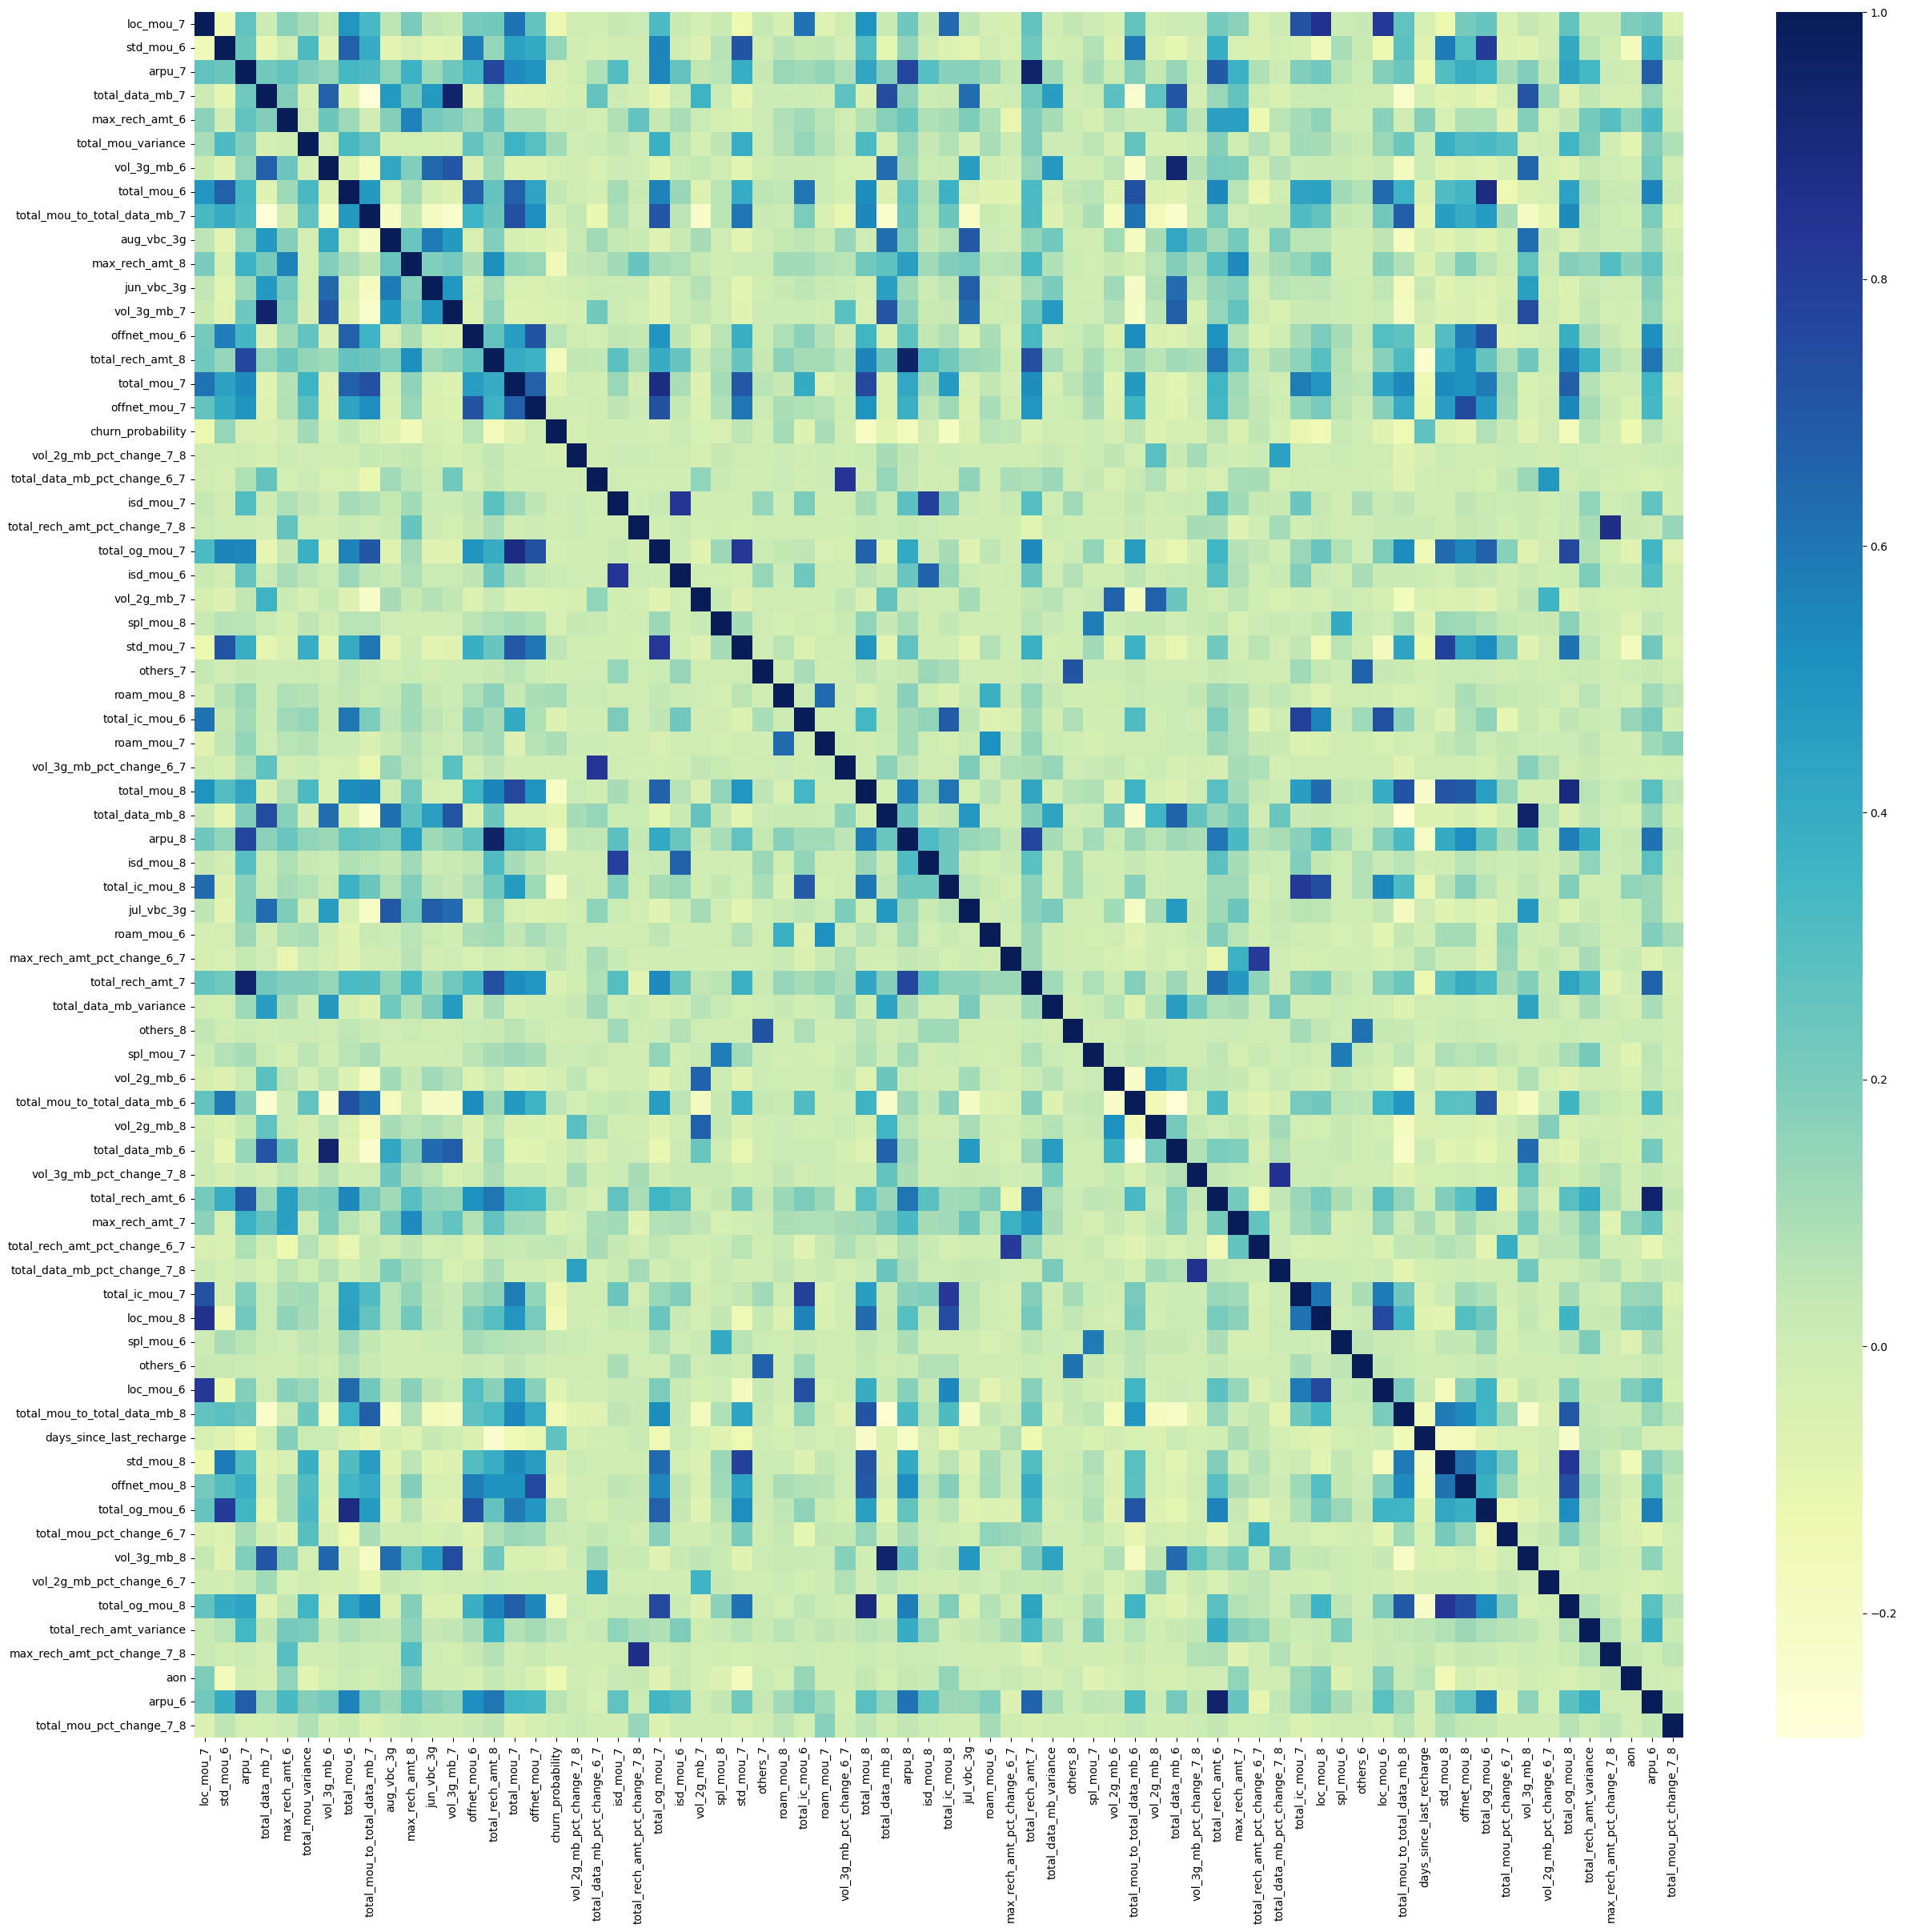

In [1093]:
plt.figure(figsize = (30,28))
sns.heatmap(data.corr(), cmap='YlGnBu')

In [1094]:
# Since large no of feature lets identify highly correlated columns and drop them

In [1095]:
corr_matrix = data.corr().abs()
corr_matrix

,loc_mou_7,std_mou_6,arpu_7,total_data_mb_7,max_rech_amt_6,total_mou_variance,vol_3g_mb_6,total_mou_6,total_mou_to_total_data_mb_7,aug_vbc_3g,...,total_og_mou_6,total_mou_pct_change_6_7,vol_3g_mb_8,vol_2g_mb_pct_change_6_7,total_og_mou_8,total_rech_amt_variance,max_rech_amt_pct_change_7_8,aon,arpu_6,total_mou_pct_change_7_8
loc_mou_7,1.000000,0.153435,0.267742,0.006377,0.163777,0.099041,0.016200,0.491367,0.334596,0.054543,...,0.253706,0.040910,0.030828,0.013167,0.266340,0.015092,0.022903,0.192782,0.226275,0.051338
std_mou_6,0.153435,1.000000,0.242793,0.095944,0.007862,0.321121,0.076560,0.669913,0.401598,0.091332,...,0.805743,0.064308,0.079562,0.011601,0.405524,0.056796,0.005449,0.174096,0.398390,0.045872
arpu_7,0.267742,0.242793,1.000000,0.231643,0.263979,0.188839,0.145128,0.342534,0.322775,0.153078,...,0.355128,0.095732,0.188086,0.031926,0.430439,0.346859,0.008074,0.002415,0.680644,0.023557
total_data_mb_7,0.006377,0.095944,0.231643,1.000000,0.181638,0.027650,0.667027,0.077006,0.293523,0.478855,...,0.098142,0.013613,0.707467,0.118913,0.070474,0.039623,0.022031,0.023701,0.145083,0.016024
max_rech_amt_6,0.163777,0.007862,0.263979,0.181638,1.000000,0.005412,0.239257,0.123693,0.011486,0.176907,...,0.083696,0.077980,0.181243,0.033853,0.038358,0.212316,0.297403,0.152804,0.330599,0.006883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
total_rech_amt_variance,0.015092,0.056796,0.346859,0.039623,0.212316,0.199795,0.033099,0.082340,0.054368,0.041603,...,0.088312,0.065410,0.049151,0.003741,0.075178,1.000000,0.078036,0.004815,0.385705,0.013626
max_rech_amt_pct_change_7_8,0.022903,0.005449,0.008074,0.022031,0.297403,0.005695,0.004248,0.016097,0.012482,0.004715,...,0.015876,0.008866,0.007547,0.005848,0.016747,0.078036,1.000000,0.032675,0.001899,0.050375
aon,0.192782,0.174096,0.002415,0.023701,0.152804,0.083019,0.016261,0.014338,0.010251,0.014090,...,0.061296,0.048310,0.007903,0.020270,0.036221,0.004815,0.032675,1.000000,0.002649,0.010735
arpu_6,0.226275,0.398390,0.680644,0.145083,0.330599,0.180609,0.218660,0.559717,0.198698,0.130362,...,0.568194,0.089534,0.157754,0.032841,0.283581,0.385705,0.001899,0.002649,1.000000,0.036692


In [1096]:
threshold = 0.8
corr_pair = []
n = len(corr_matrix.columns)

for i in range(n):
    for j in range(i+1,n ):
        if corr_matrix.iloc[i, j]> threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            corr_pair.append((col1, col2, round(corr_value, 2)))


            

In [1097]:
corr_pair, len(set(corr_pair))

([('loc_mou_7', 'loc_mou_8', np.float64(0.85)),
  ('loc_mou_7', 'loc_mou_6', np.float64(0.82)),
  ('std_mou_6', 'total_og_mou_6', np.float64(0.81)),
  ('arpu_7', 'total_rech_amt_7', np.float64(0.95)),
  ('total_data_mb_7', 'vol_3g_mb_7', np.float64(0.94)),
  ('vol_3g_mb_6', 'total_data_mb_6', np.float64(0.94)),
  ('total_mou_6', 'total_og_mou_6', np.float64(0.89)),
  ('total_rech_amt_8', 'arpu_8', np.float64(0.96)),
  ('total_mou_7', 'total_og_mou_7', np.float64(0.89)),
  ('total_data_mb_pct_change_6_7',
   'vol_3g_mb_pct_change_6_7',
   np.float64(0.84)),
  ('isd_mou_7', 'isd_mou_6', np.float64(0.83)),
  ('total_rech_amt_pct_change_7_8',
   'max_rech_amt_pct_change_7_8',
   np.float64(0.87)),
  ('total_og_mou_7', 'std_mou_7', np.float64(0.82)),
  ('total_mou_8', 'total_og_mou_8', np.float64(0.9)),
  ('total_data_mb_8', 'vol_3g_mb_8', np.float64(0.95)),
  ('total_ic_mou_8', 'total_ic_mou_7', np.float64(0.82)),
  ('max_rech_amt_pct_change_6_7',
   'total_rech_amt_pct_change_6_7',
   np.

In [1098]:
data[['loc_mou_7', 'loc_mou_6', 'loc_mou_8']].corr()

,loc_mou_7,loc_mou_6,loc_mou_8
loc_mou_7,1.000000,0.821893,0.854196
loc_mou_6,0.821893,1.000000,0.760791
loc_mou_8,0.854196,0.760791,1.000000


In [1099]:
# lets drop high correlated column

data = data.drop(
['arpu_6', 'arpu_7', 'arpu_8',
'std_mou_6', 'std_mou_8',
'loc_mou_6', 'loc_mou_7',
'isd_mou_6', 'isd_mou_7',
 'vol_3g_mb_6', 'vol_3g_mb_7','vol_3g_mb_8',
 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8'
], axis=1)


In [1100]:
len(data.columns)

57

In [1105]:
data.head()

,total_data_mb_7,max_rech_amt_6,total_mou_variance,total_mou_6,total_mou_to_total_data_mb_7,aug_vbc_3g,max_rech_amt_8,jun_vbc_3g,offnet_mou_6,total_rech_amt_8,...,others_6,total_mou_to_total_data_mb_8,days_since_last_recharge,offnet_mou_8,total_mou_pct_change_6_7,vol_2g_mb_pct_change_6_7,total_rech_amt_variance,max_rech_amt_pct_change_7_8,aon,total_mou_pct_change_7_8
id,,,,,,,,,,,,,,,,,,,,,
11,0.0,110,21541.681200,315.87,28377000.0,0.0,130,0.0,46.39,460,...,0.00,5.525100e+07,4,92.81,-10.162408,0.000000,16033.333333,159.999968,648,94.703454
12,0.0,110,7294.809900,850.93,87157000.0,0.0,50,0.0,571.98,365,...,0.00,7.144000e+07,1,644.43,2.425581,0.000000,6292.333333,-54.545450,322,-18.032975
14,0.0,150,2312.085833,643.39,54724000.0,0.0,150,0.0,98.51,300,...,9.97,5.969400e+07,6,150.61,-14.944279,0.000000,33233.333333,24.999998,1049,9.081938
15,0.0,250,94594.176033,560.82,114418000.0,0.0,250,0.0,317.11,652,...,0.10,2.882658e+00,1,197.09,104.019113,-99.999996,21337.333333,0.000000,602,-10.724711
22,0.0,169,33653.878900,736.52,108874000.0,0.0,279,0.0,335.41,327,...,0.00,1.001610e+08,10,281.06,47.822190,0.000000,532.000000,65.088754,2837,-8.002829


In [1106]:
# Check Target Column. data is baised

In [1107]:
data['churn_probability'].value_counts() * 100/len(data)

churn_probability
0    91.126104
1     8.873896
Name: count, dtype: float64

In [1108]:
# lets Drop X and Y since it has onyl one value

# filter high value customer

get the rech amount mean for month 6, 7 and select customer top 30 quantile 

2- EDA

In [1109]:
# unvariant analysis : lots of outlier

In [1110]:
# plt.figure(figsize=(20,10))
# plt.xticks(rotation=45)
# sns.boxplot(data=data)

In [1111]:
# bivariant analysis - num  vs num
# bivariant with target

In [1112]:
# sns.pairplot(data)



In [1113]:
# #Distribution for the churn probability
# sns.histplot(data['churn_probability'])

In [1114]:
# plt.figure(figsize=(20,18))
# sns.heatmap(data.corr(), annot=True, cmap = 'YlGnBu')

# 3. Create X, y and then Train test split

(34979, 56) (34979,)


In [1116]:
# Splitting data into train and test

In [1117]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= 0.2)

X_train.shape,  X_test.shape, y_train.shape, y_test.shape

((27983, 56), (6996, 56), (27983,), (6996,))

In [1118]:
# check class balance in test and train data

# y_test_f.value_counts()/len(y_test)
# y_train_f.value_counts()/len(y_train)

new_vars = X_train.columns

In [1119]:
len(new_vars)

56

In [1120]:
X_train.head()

,total_data_mb_7,max_rech_amt_6,total_mou_variance,total_mou_6,total_mou_to_total_data_mb_7,aug_vbc_3g,max_rech_amt_8,jun_vbc_3g,offnet_mou_6,total_rech_amt_8,...,others_6,total_mou_to_total_data_mb_8,days_since_last_recharge,offnet_mou_8,total_mou_pct_change_6_7,vol_2g_mb_pct_change_6_7,total_rech_amt_variance,max_rech_amt_pct_change_7_8,aon,total_mou_pct_change_7_8
id,,,,,,,,,,,,,,,,,,,,,
29784,0.0,250,6245.610233,594.27,6.772900e+07,0.00,130,0.00,255.99,260,...,0.80,5.193000e+07,1,199.98,13.970081,0.000000,36400.000000,0.000000,3233,-23.326787
68509,0.0,30,4249.456633,406.80,3.609000e+07,0.00,30,0.00,143.54,300,...,0.00,2.781700e+07,0,186.46,-11.283186,0.000000,1836.333333,-9.090906,235,-22.923247
11836,1965.1,252,10.543633,37.20,1.874205e-02,111.96,252,1456.38,3.69,426,...,0.00,1.781900e-02,5,28.79,-0.994623,-99.999993,34644.000000,0.000000,664,15.748027
69645,0.0,120,12798.038233,828.42,9.297500e+07,0.00,150,0.00,593.38,386,...,2.91,7.038900e+07,3,507.48,12.231718,0.000000,4905.333333,0.000000,446,-24.292551
8841,0.0,90,54821.662233,636.84,5.625000e+07,0.00,130,0.00,346.51,342,...,0.00,1.000070e+08,0,706.13,-11.673262,0.000000,12240.333333,1.562500,595,77.790221


# 4. Preprocessing

## 4.1 handling missing data

In [1121]:
X_train_filtered = X_train.copy()

In [1122]:
# Lets analyse missing data

In [1123]:
missing_per = X_train_filtered.isna().mean()*100
missing_per


total_data_mb_7                  0.000000
max_rech_amt_6                   0.000000
total_mou_variance               0.000000
total_mou_6                      0.000000
total_mou_to_total_data_mb_7     0.000000
aug_vbc_3g                       0.000000
max_rech_amt_8                   0.000000
jun_vbc_3g                       0.000000
offnet_mou_6                     1.529500
total_rech_amt_8                 0.000000
total_mou_7                      0.000000
offnet_mou_7                     1.475896
vol_2g_mb_pct_change_7_8         0.000000
total_data_mb_pct_change_6_7     0.000000
total_rech_amt_pct_change_7_8    0.000000
vol_2g_mb_7                      0.000000
spl_mou_8                        3.687953
std_mou_7                        1.475896
others_7                         1.475896
roam_mou_8                       3.687953
total_ic_mou_6                   0.000000
roam_mou_7                       1.475896
vol_3g_mb_pct_change_6_7         0.000000
total_mou_8                      0

In [1124]:
# Since lots if missing value in some column . drop column with more than 40% missing values

Apply imputation on missing data. 
 We can use either
 1. constant value
 2. mean or median 
 3. Use MICE

 Lets use simple constant value for now

In [1125]:
impute_cols = X_train_filtered.columns[X_train_filtered.isna().any()]
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'spl_mou_8', 'std_mou_7', 'others_7',
       'roam_mou_8', 'roam_mou_7', 'isd_mou_8', 'roam_mou_6', 'others_8',
       'spl_mou_7', 'loc_mou_8', 'spl_mou_6', 'others_6', 'offnet_mou_8'],
      dtype='object')

In [1126]:
# len(X_train_filtered.columns)

In [1127]:
si = KNNImputer(n_neighbors=10)
X_train_filtered[impute_cols] = si.fit_transform(X_train_filtered[impute_cols])

In [1128]:
# check if there are any null after imputation

In [1129]:
X_train_filtered.isna().any().sum()

np.int64(0)

## 4.2 handling outlier

Box plot clearly shpw there are lots if outlier. We can deal with them either
1. 1.5 * IQR
2. K sigma 
lets use K = 3 sigma for now and kap the outlier to lower and upper limit

In [1130]:
def cap_outliers(array , k =3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array < lower_limit ] = lower_limit
    array[array > upper_limit] = upper_limit
    return array


<Axes: >

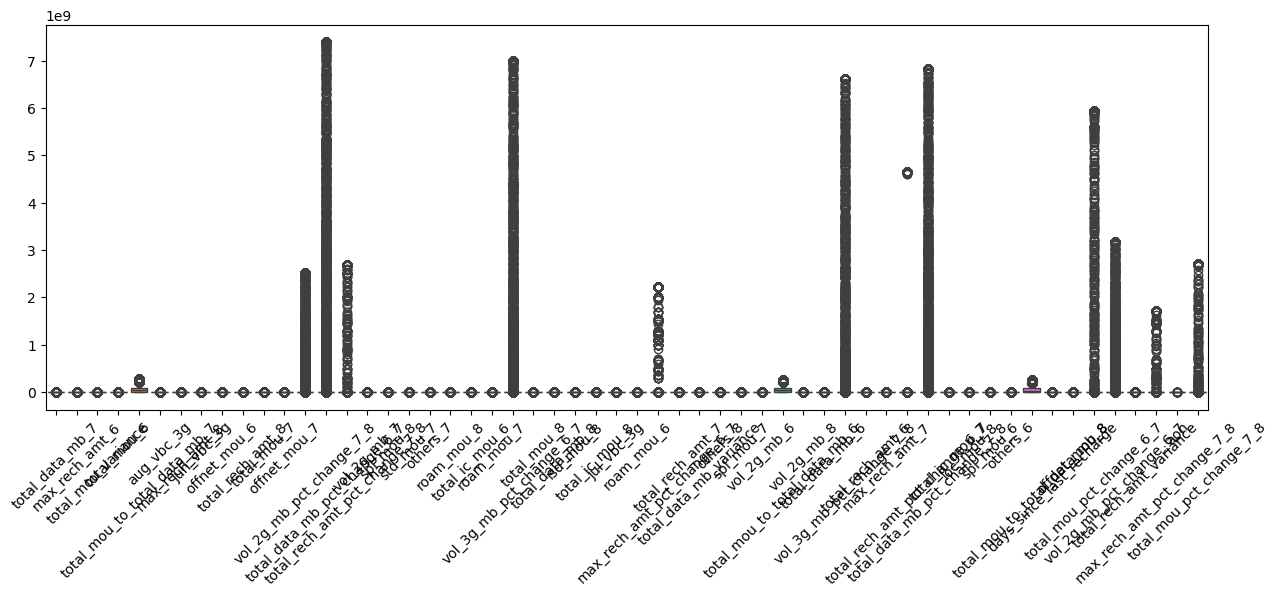

In [1131]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis = 0)

# axis = 1 along the column ➡️ Right
# axis = 0 along the rows ⬇️ 


plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.boxplot(data=X_train_filtered1)

## 4.3 Feature scaling

In [1132]:
sc = StandardScaler()
X_train_filtered2 = sc.fit_transform(X_train_filtered1)

In [1133]:
X_train_filtered2 = pd.DataFrame(X_train_filtered2, columns = X_train_filtered1.columns)

<Axes: >

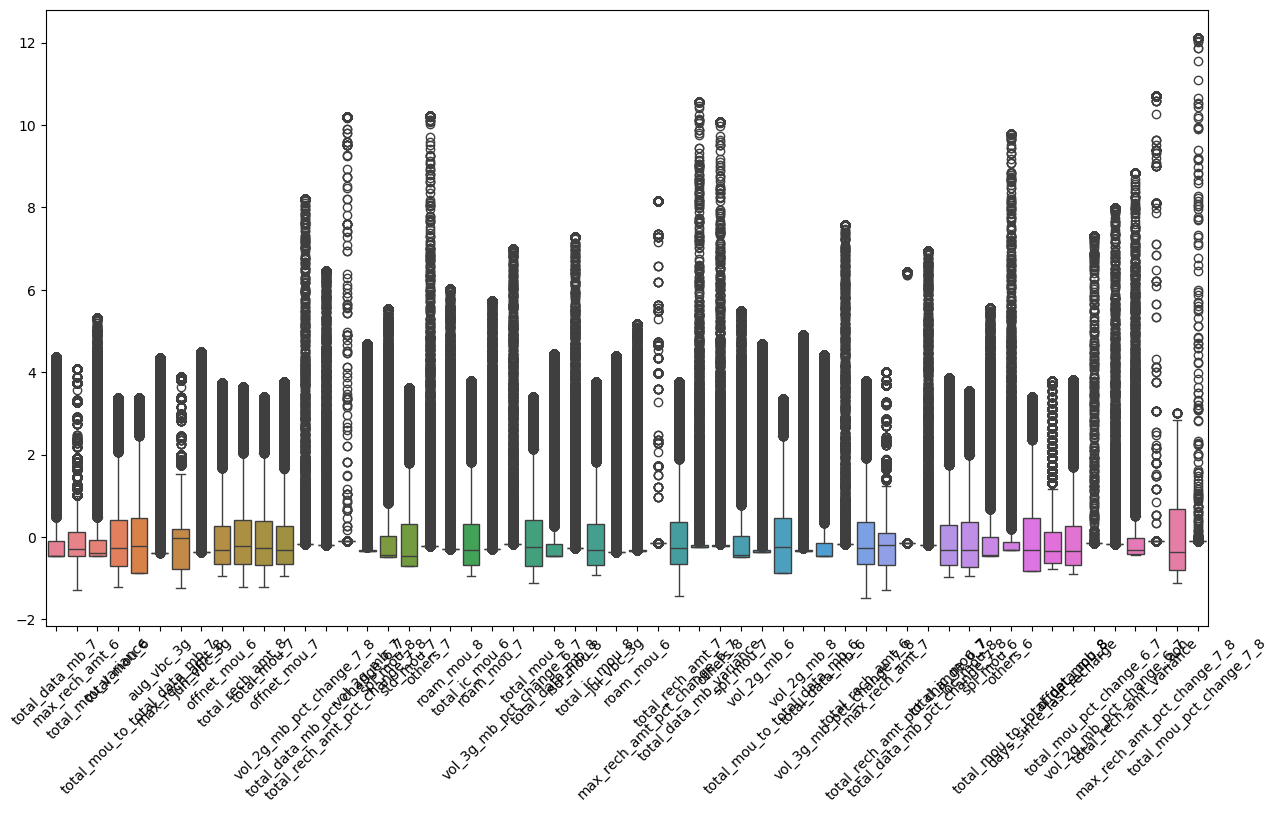

In [1134]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data= X_train_filtered2)

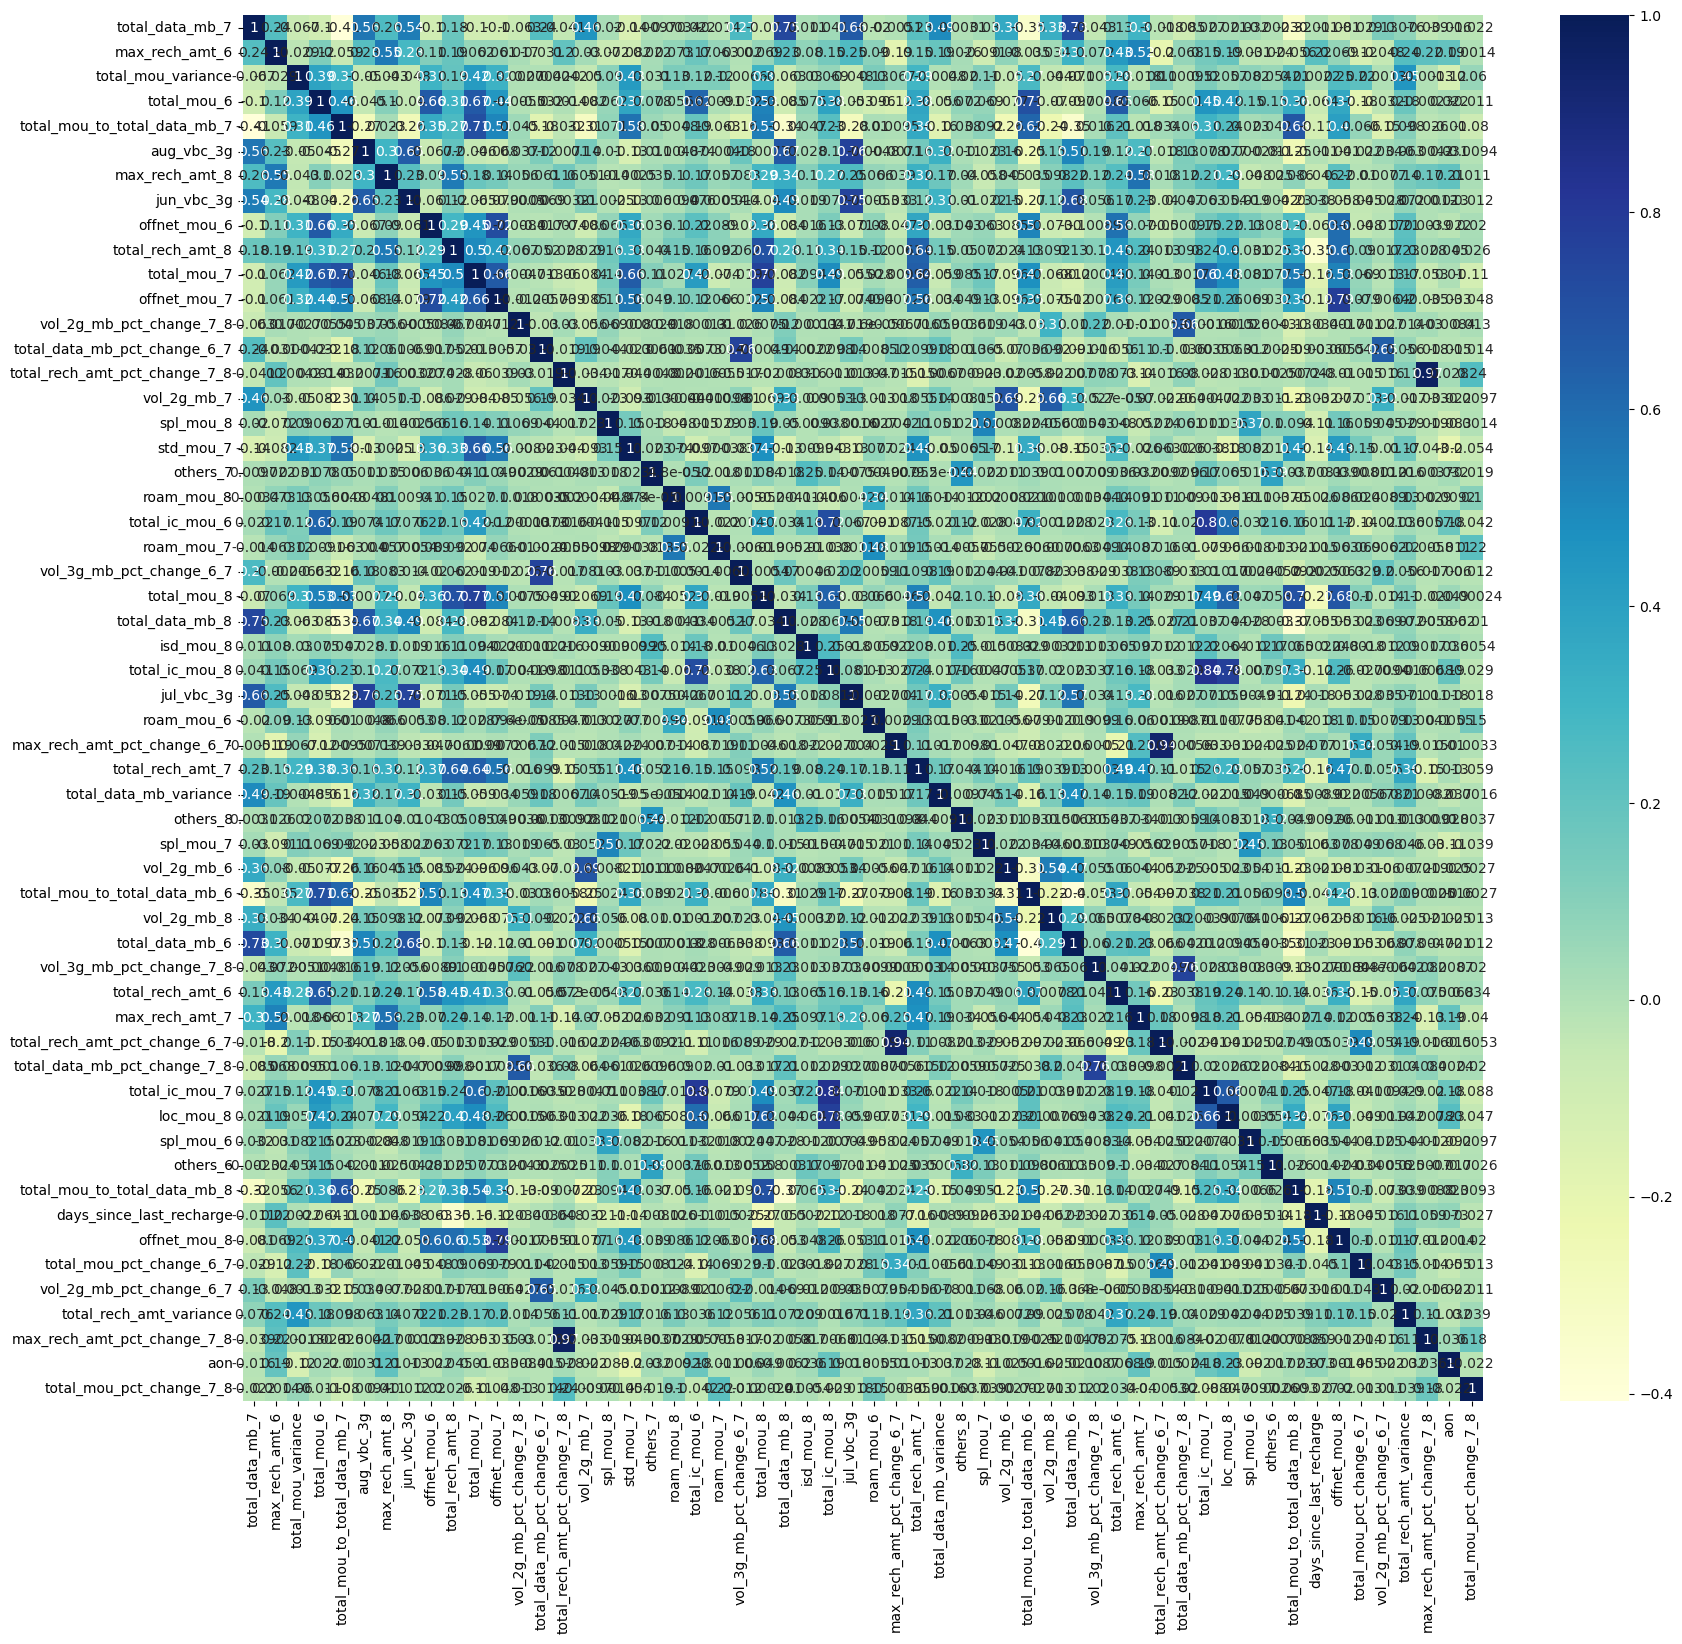

In [1135]:
plt.figure(figsize=(20,18))
sns.heatmap(data = X_train_filtered2.corr(), cmap= 'YlGnBu' , annot=True)
plt.show()

# 5. Feature engineering and selection

 Lets understand feature importance

In [1136]:
y_train.shape, X_train.shape, X_train_filtered2.shape, y_train.shape

((27983,), (27983, 56), (27983, 56), (27983,))

In [1137]:
rf = RandomForestClassifier(n_estimators = 100, random_state=110, n_jobs=10)
rf = rf.fit(X_train_filtered2, y_train)


Feature importance :  
total_ic_mou_8
total_og_mou_8
arpu_8
roam_og_mou_8
max_rech_amt_8
last_day_rch_amt_8
Recharge Amount
days_since_last_rechard
aon

<!-- Average Age in Network (AON), Minute of outgoing calls to other network(offnet_mou),  Minute of outgoing calls total(total_og_mou), Total  -->

In [1138]:
importance_df = pd.DataFrame( {'value' : rf.feature_importances_*100,
                               'name':list(X_train_filtered2.columns)\
})

importance_df.sort_values(by='value', ascending=False)

,value,name
26,11.941980,total_ic_mou_8
23,11.788750,total_mou_8
9,5.619856,total_rech_amt_8
19,4.570432,roam_mou_8
6,4.562957,max_rech_amt_8
44,3.367134,loc_mou_8
47,2.927516,total_mou_to_total_data_mb_8
48,2.692224,days_since_last_recharge
43,2.687232,total_ic_mou_7
52,2.499151,total_rech_amt_variance


In [1139]:
important_features = importance_df[importance_df['value'] > 0.5]


In [1140]:
important_features

,value,name
0,0.669899,total_data_mb_7
1,1.352982,max_rech_amt_6
2,2.476922,total_mou_variance
3,1.675289,total_mou_6
4,1.489932,total_mou_to_total_data_mb_7
6,4.562957,max_rech_amt_8
8,1.807002,offnet_mou_6
9,5.619856,total_rech_amt_8
10,2.215706,total_mou_7
11,1.901612,offnet_mou_7


In [1141]:
new_vars = list(important_features['name'])

In [1142]:
new_vars, len(new_vars)

(['total_data_mb_7',
  'max_rech_amt_6',
  'total_mou_variance',
  'total_mou_6',
  'total_mou_to_total_data_mb_7',
  'max_rech_amt_8',
  'offnet_mou_6',
  'total_rech_amt_8',
  'total_mou_7',
  'offnet_mou_7',
  'spl_mou_8',
  'std_mou_7',
  'others_7',
  'roam_mou_8',
  'total_ic_mou_6',
  'roam_mou_7',
  'total_mou_8',
  'total_data_mb_8',
  'isd_mou_8',
  'total_ic_mou_8',
  'roam_mou_6',
  'max_rech_amt_pct_change_6_7',
  'total_rech_amt_7',
  'total_data_mb_variance',
  'others_8',
  'spl_mou_7',
  'total_mou_to_total_data_mb_6',
  'vol_2g_mb_8',
  'total_data_mb_6',
  'total_rech_amt_6',
  'max_rech_amt_7',
  'total_ic_mou_7',
  'loc_mou_8',
  'spl_mou_6',
  'others_6',
  'total_mou_to_total_data_mb_8',
  'days_since_last_recharge',
  'offnet_mou_8',
  'total_rech_amt_variance',
  'max_rech_amt_pct_change_7_8',
  'aon'],
 41)

In [1143]:
# create new feature, average change 

# in usage
# average % gain of 3g volumne

In [1144]:
X_train_filtered2.head()

,total_data_mb_7,max_rech_amt_6,total_mou_variance,total_mou_6,total_mou_to_total_data_mb_7,aug_vbc_3g,max_rech_amt_8,jun_vbc_3g,offnet_mou_6,total_rech_amt_8,...,others_6,total_mou_to_total_data_mb_8,days_since_last_recharge,offnet_mou_8,total_mou_pct_change_6_7,vol_2g_mb_pct_change_6_7,total_rech_amt_variance,max_rech_amt_pct_change_7_8,aon,total_mou_pct_change_7_8
0,-0.464756,0.998290,-0.450562,-0.269783,0.184318,-0.375340,-0.033469,-0.358103,-0.164559,-0.545246,...,-0.130087,0.031289,-0.630857,-0.267355,-0.147683,-0.171076,-0.225735,-0.104183,2.043097,-0.090834
1,-0.464756,-1.018236,-0.456676,-0.563393,-0.311856,-0.375340,-0.949863,-0.358103,-0.512733,-0.440964,...,-0.322748,-0.363250,-0.780233,-0.310232,-0.147683,-0.171076,-0.430206,-0.104183,-1.052978,-0.090834
2,3.126770,1.016622,-0.469658,-1.142248,-0.877833,0.098973,1.084532,4.490984,-0.945744,-0.112477,...,-0.322748,-0.818393,-0.033355,-0.810272,-0.147683,-0.171076,-0.236123,-0.104183,-0.609944,-0.090834
3,-0.464756,-0.193294,-0.430495,0.096935,0.580235,-0.375340,0.149810,-0.358103,0.880086,-0.216758,...,0.378055,0.333316,-0.332106,0.707859,-0.147683,-0.171076,-0.412050,-0.104183,-0.835076,-0.090834
4,-0.464756,-0.468274,-0.301793,-0.203111,0.004300,-0.375340,-0.033469,-0.358103,0.115714,-0.331469,...,-0.322748,0.817928,-0.780233,1.337864,-0.147683,-0.171076,-0.368658,-0.104183,-0.681201,-0.090833


In [1145]:
# X_train_filtered2['avg_per_gain_3g'] = (X_train_filtered2['vol_3g_mb_6'] - X_train_filtered2['vol_3g_mb_7'])/ X_train_filtered2['vol_3g_mb_6']
# X_train_filtered2= X_train_filtered2.drop('avg_per_gain_3g', axis =1 )

#TODO : Crete New features
1.  "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. data['recharge_data_ratio'] = data['recharge_data_mnth'] / (data['total_recharge_mnth'] + 1)
4. data['outgoing_calls_recharge'] = data['total_outgoing_call_mnth'] * data['recharge_amt_mnt']



Lets Apply SMOTE for class imbalance as the Random forest return all class level as 0

In [1146]:
# X_train_filtered_f, y_train_f = X_train_filtered2, y_train
# X_train_filtered_f.shape, y_train_f.shape, X_train_filtered2.shape, y_train.shape

In [1147]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=110)
# X_train_filtered_f, y_train_f = smote.fit_resample(X_train_filtered2, y_train)


In [1148]:
# X_train_filtered2.shape, y_train.shape, X_train_filtered_f.shape, y_train_f.shape

 lets use PCA to create new feature


In [1149]:
# pca = PCA(0.9)
# pca_components = pca.fit_transform(X_train_filtered_f)

# sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train_f)

In [1150]:
# rf = RandomForestClassifier()
# rf.fit(pca_components, y_train_f)
# feature_importance_df = pd.DataFrame( 
#     {'value' : rf.feature_importances_, 'name':['comp_'+ str(i) for i in range(len(rf.feature_importances_))]}
# ) 

In [1151]:
# plt.figure(figsize=(15,8))
# plt.xticks(rotation=45)
# sns.barplot(x=feature_importance_df['name'], y =feature_importance_df['value'])


# Smote

In [1152]:


# smote = SMOTE(random_state=110)
# X_train_filtered_f, y_train_f = smote.fit_resample(X_train_filtered2, y_train)

# 6 - Modelling 

lets create model with logistci regression on 2 PCA componenet

In [1153]:
# lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
# lr.fit(pca_components[:,:2], y_train_f)

In [1154]:
# accuracy_score(y_train_f, lr.predict(pca_components[:,:2]))

model has 89% accuracy

lets create a pipeline

In [1158]:
# new_vars

In [1160]:
len(new_vars)

41

In [1159]:
# new_vars

In [1161]:
# process test data

X_train_f = X_train[new_vars]
y_train_f = y_train

X_test_f = X_test[new_vars]
y_test_f = y_test



In [1162]:
X_train_f.shape

(27983, 41)

#-----------------------------------------------------------------------------# SVM

In [1163]:
imp = KNNImputer(n_neighbors=10)
outlier_transformer = FunctionTransformer(func=cap_outliers, validate=False)
scale = StandardScaler()
smote = SMOTE(random_state=110)
pca = PCA(0.95) # modify to variance .95
svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=110)

In [1164]:
pipe_svm = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', svm)
])


In [1165]:
len(X_train_f.columns)

41

In [ ]:
pipe_svm.fit(X_train_f, y_train_f)

In [ ]:
# 89 on 22 columns
train_score = pipe_svm.score(X_train_f, y_train_f)
print("Training accuracy:", train_score)

In [ ]:
test_score = pipe_svm.score(X_test_f, y_test_f)
print("Test accuracy:", test_score)

#-----------------------------------------------------------------------------# logistic regression

In [1166]:
imp = KNNImputer(n_neighbors=10)
outlier_transformer = FunctionTransformer(func=cap_outliers, validate=False)
scale = StandardScaler()
# smote = SMOTE(random_state=110)
pca = PCA(0.90) # modify to variance .95
lr = LogisticRegression(max_iter=100)




In [1167]:
pipe_lr = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', lr)
])


In [1168]:
pipe_lr.fit(X_train_f, y_train_f)

Pipeline(steps=[('imputation', KNNImputer(n_neighbors=10)),
                ('outlier',
                 FunctionTransformer(func=<function cap_outliers at 0x17f665080>)),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('model', LogisticRegression())])

In [1169]:
# 89 on 22 columns
train_score = pipe_lr.score(X_train_f, y_train_f)
print("Training accuracy:", train_score)

Training accuracy: 0.9184147518136011


In [1170]:
test_score = pipe_lr.score(X_test_f, y_test_f)
print("Test accuracy:", test_score)

Test accuracy: 0.9138078902229846


In [ ]:
#-----------------------------------------------------------------------------# random forest

In [1171]:
rf = RandomForestClassifier(random_state=110, n_jobs=10, n_estimators=200, max_depth = 4 )
pipe_rf = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', rf)
])


In [1172]:
pipe_rf.fit(X_train_f, y_train_f )

Pipeline(steps=[('imputation', KNNImputer(n_neighbors=10)),
                ('outlier',
                 FunctionTransformer(func=<function cap_outliers at 0x17f665080>)),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('model',
                 RandomForestClassifier(max_depth=4, n_estimators=200,
                                        n_jobs=10, random_state=110))])

In [1173]:
train_score = pipe_rf.score(X_train_f, y_train_f)
print("Training accuracy:", train_score)

Training accuracy: 0.9153771932959297


In [1174]:
test_score = pipe_rf.score(X_test_f, y_test_f)
print("Test accuracy:", test_score)

Test accuracy: 0.9108061749571184


#-----------------------------------------------------------------------------# XGBoost

In [1179]:
xgb = XGBClassifier(random_state=110, n_jobs=10, max_depth=4)

pipe_xgb = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', xgb)
])


In [1180]:
pipe_xgb.fit(X_train_f, y_train_f)

Pipeline(steps=[('imputation', KNNImputer(n_neighbors=10)),
                ('outlier',
                 FunctionTransformer(func=<function cap_outliers at 0x17f665080>)),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stoppin...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=10,
                               num_parallel_tree=None, random_state=110, ...))])

In [1181]:
train_score = pipe_xgb.score(X_train_f, y_train_f)
print("Training accuracy:", train_score)

Training accuracy: 0.95407926240932


In [1182]:
test_score = pipe_xgb.score(X_test_f, y_test_f)
print("Test accuracy:", test_score)

Test accuracy: 0.9213836477987422


-----------------------------------------------------LR Pred

In [ ]:
# utility function
def get_score_confusion_matrix(pipeline_to, X_data_to, y_data_to):
    print('accuracy score : ',accuracy_score(y_data_to, pipeline_to.predict(X_data_to)))
    print( 'confustion matrix : ' ,confusion_matrix(y_data_to, pipeline_to.predict(X_data_to)))


In [ ]:
# pipe = pipe_lr
# pipe.fit(X_train_filtered, y_train)
# accuracy_score(y_train, pipe.predict(X_train_filtered))
#confusion_matrix(y_train, pipe.predict(X_train_filtered))
# (tn, fp, fn, tp) = cm.ravel()
# (tn, fp, fn, tp) # positive = churn = 1 # negative = non-churn = 0 false positive are high

-----------------------------------------------------LR Pred

# Prediction

In [ ]:
# --Train accuracy
# get_score_confusion_matrix(pipe_lr, X_train_f, y_train_f)

In [ ]:
# --Test accuracy
# get_score_confusion_matrix(pipe_lr, X_test_f, y_test_f)

-----------------------------------------------------RandomForesr Pred

In [ ]:
# --Train accuracy : Random Forest
# get_score_confusion_matrix(pipe_rf, X_train_f, y_train_f)

In [ ]:
# --Test accuracy : Random Forest
# get_score_confusion_matrix(pipe_rf,  X_test_f, y_test_f)

-----------------------------------------------------XGB Pred

In [ ]:
# --Train accuracy : XGBoost
# get_score_confusion_matrix(pipe_xgb, X_train_f, y_train_f)

In [ ]:
# --Test accuracy : XGBoost
# get_score_confusion_matrix(pipe_xgb,  X_test_f, y_test_f)

# HyperParameter Tuning


In [1183]:
pca = PCA(0.95)

----------------------------------------------------------------XGB

In [1184]:
xgb_t = XGBClassifier(random_state=110, n_jobs=10)

pipe_xgb_t = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', xgb_t)
])
## Define parameters
param_grid_xgb_t = {
'model__max_depth':[3,4,5],
'model__learning_rate' : [0.01, 0.05, 0.1],
'model__min_child_weight': [1, 2, 3],
'model__colsample_bytree': [0.6, 0.8], 
'model__gamma':[0.5, 1, 5],
'model__reg_lambda':[5, 10, 15],
'model__reg_alpha':[0.1, 0.5, 1, 5],
'model__subsample':[0.5, 0.7, 0.8]
}
# Stratified
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [1185]:
random_search_xgb_t = RandomizedSearchCV(estimator=pipe_xgb_t, param_distributions=param_grid_xgb_t,
    n_iter=20,  # Number of parameter settings sampled
    scoring='accuracy', 
    cv=stratified_kfold, 
    verbose=2,  
    n_jobs=-1,  
    random_state=110 
)
# Fit the RandomizedSearchCV to the data
random_search_xgb_t.fit(X_train_f, y_train_f)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('imputation',
                                              KNNImputer(n_neighbors=10)),
                                             ('outlier',
                                              FunctionTransformer(func=<function cap_outliers at 0x17f665080>)),
                                             ('scaling', StandardScaler()),
                                             ('pca', PCA(n_components=0.95)),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            co...
                                                            random_state=110, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.6, 0.8],
                                        'model__gamma': [0.5, 1, 5],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [3, 4, 5],
                                        'model__min_child_weight': [1, 2, 3],
                                        'model__reg_alpha': [0.1, 0.5, 1, 5],
                                        'model__reg_lambda': [5, 10, 15],
                                        'model__subsample': [0.5, 0.7, 0.8]},
                   random_state=110, scoring='accuracy', verbose=2)

In [1186]:
random_search_xgb_t.best_params_

{'model__subsample': 0.8,
 'model__reg_lambda': 15,
 'model__reg_alpha': 1,
 'model__min_child_weight': 1,
 'model__max_depth': 5,
 'model__learning_rate': 0.1,
 'model__gamma': 1,
 'model__colsample_bytree': 0.6}

In [1187]:
xgb_t_model = random_search_xgb_t.best_estimator_
y_pred = xgb_t_model.predict(X_train_f)
print(accuracy_score(y_train_f, y_pred))

0.9432512596933853


In [1188]:
# xgb_t_model = random_search_xgb_t.best_estimator_
y_pred_t = xgb_t_model.predict(X_test_f)
print(accuracy_score(y_test_f, y_pred_t))

0.9219554030874786


----------------------------------------------------------------Random Forest

In [ ]:
rf_t = RandomForestClassifier(random_state=110, n_jobs=10)
pipe_rf_t = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', rf_t)
])

param_grid_rf_t = {
'model__n_estimators':[100,150,200],
'model__max_depth':[3,5,7],
'model__min_samples_split':[10,20,30,40],
'model__max_leaf_nodes':[20,40,60]
}

In [ ]:
# Initialize RandomizedSearchCV with StratifiedKFold
random_search_rf_t = RandomizedSearchCV(estimator=pipe_rf_t, param_distributions=param_grid_rf_t,
    n_iter=20,  # Number of parameter settings sampled
    scoring='accuracy',  # Scoring metric
    cv=stratified_kfold,  # Use StratifiedKFold
    verbose=2,  # Verbosity level
    n_jobs=-1,  # Use all available CPU cores
    random_state=110  # Seed for reproducibility
)
# Fit the RandomizedSearchCV to the data
random_search_rf_t.fit(X_train_f, y_train_f)

In [ ]:
X_train_f.shape, X_test_f.shape

In [ ]:
rf_t_model = random_search_rf_t.best_estimator_
y_pred = rf_t_model.predict(X_train_f)
print(accuracy_score(y_train_f, y_pred))

In [ ]:
# best_model = random_search_rf_t.best_estimator_
y_pred_t = rf_t_model.predict(X_test_f)
print(accuracy_score(y_test_f, y_pred_t))

----------------------------------------------------------------SVC

In [ ]:
svc_t = SVC(random_state=110)
pipe_svc_t = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', svc_t)
])

param_grid_svc_t = {
    'model__C': [0.1, 1, 10, 100],  # Regularization parameter
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'model__degree': [2, 3, 4],  # Degree of polynomial kernel, if 'poly' is used
    'model__class_weight': [None, 'balanced']  # Handling of class imbalance
}

In [ ]:
# # Initialize RandomizedSearchCV with StratifiedKFold
random_search_svc_t = RandomizedSearchCV(estimator=pipe_svc_t, param_distributions=param_grid_svc_t,
    n_iter=5,  # Number of parameter settings sampled
    scoring='accuracy',  # Scoring metric
    cv=stratified_kfold,  # Use StratifiedKFold
    verbose=2,  # Verbosity level
    n_jobs=-1,  # Use all available CPU cores
    random_state=110  # Seed for reproducibility
)
# Fit the RandomizedSearchCV to the data
random_search_svc_t.fit(X_train_f, y_train_f)

In [ ]:
svc_t_model = random_search_svc_t.best_estimator_
y_pred = svc_t_model.predict(X_train_f)
print(accuracy_score(y_train_f, y_pred))

In [ ]:
# best_model = random_search_rf_t.best_estimator_
y_pred_t = svc_t_model.predict(X_test_f)
print(accuracy_score(y_test_f, y_pred_t))

In [ ]:
# %timeit
# param_grid_rf = {
# 'model__n_estimators':[100,150,200],
# 'model__max_depth':[3,5,7],
# 'model__min_samples_split':[10,20,30,40],
# 'model__max_leaf_nodes':[20,40,60]
# }
# cv_rf = GridSearchCV(estimator=pipe_rf, n_jobs=8, param_grid = param_grid_rf, verbose=2, cv=5, scoring='accuracy')
# cv_rf.fit(X_train_f, y_train_f)

# stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# rf_best_params_ = {max_depth=10, max_leaf_nodes=80, min_samples_split=40,
#                        n_estimators=150}

In [ ]:
# cv.best_estimator_

In [ ]:
# %timeit
# param_grid_xgb = {
# 'model__max_depth':[3, 6, 9],
# 'model__learning_rate' : [0.01, 0.1, 0.2],
# # 'model__min_child_weight': [1, 3, 5],
# # 'model__colsample_bytree': [0.8, 0.9, 1.0], 
# 'model__gamma':[0, 0.1, 0.2],
# 'model__reg_lambda':[1,2,5],
# 'model__subsample':[0.8]
# }

# cv_xgb = GridSearchCV(estimator=pipe_xgb, n_jobs=8, param_grid = param_grid_xgb, verbose=2, cv=5, scoring='accuracy')
# cv_xgb.fit(X_train_f, y_train_f)

In [ ]:
# param_grid_xgb = {
# 'model__max_depth':[3,6,9],
# 'model__learning_rate' : [0.01, 0.1, 0.2],
# 'model__min_child_weight': [1, 3, 5],
# 'model__colsample_bytree': [0.8, 0.9, 1.0], 
# 'model__gamma':[0, 0.1, 0.2],
# 'model__reg_lambda':[1,2,5,10],
# 'model__subsample':[0.8]
# }

# # cv_xgb.best_params_
# {'model__colsample_bytree': 0.9,
#  'model__gamma': 0,
#  'model__learning_rate': 0.1,
#  'model__max_depth': 3,
#  'model__min_child_weight': 3,
#  'model__n_estimators': 150,
#  'model__reg_lambda': 10,
#  'model__subsample': 0.8}

In [ ]:
# cv.best_estimator_

In [ ]:
# rft = RandomForestClassifier(max_depth=7, max_leaf_nodes=60, min_samples_split=10,
#                        n_estimators=150)
# pipe_rft = Pipeline([
#     ('imputation', imp),
#     ('outlier', outlier_transformer),
#     ('scaling', scale),
#     ('pca', pca),
#     ('model', rft)
# ])

# pipe_rft.fit(X_train_f, y_train_f)

In [ ]:
# get_score_confusion_matrix(pipe_rf_t, X_train_f, y_train_f)

In [ ]:
# get_score_confusion_matrix(pipe_rf_t,  X_test_f, y_test_f)

In [ ]:
# xgbt = XGBClassifier(colsample_bytree= 0.9,
#   gamma= 0,
#  learning_rate= 0.1,
#  max_depth= 3,
#  min_child_weight= 3,
#  n_estimators= 150,
#  reg_lambda= 10,
#  subsample= 0.8)

# pipe_xgbt = Pipeline([
#     ('imputation', imp),
#     ('outlier', outlier_transformer),
#     ('scaling', scale),
#     ('pca', scale),
#     ('model', xgbt)
# ])

# pipe_xgbt.fit(X_train_f, y_train_f)


In [ ]:
# get_score_confusion_matrix(pipe_xgbt, X_train_f, y_train_f)

In [ ]:
# get_score_confusion_matrix(pipe_xgbt,  X_test_f, y_test_f)

# 7. Creating submission file

Sample output file will contain custmer_id, prediction

In [1189]:
# load test file
unseen_data = pd.read_csv('./kaggle/input/test.csv')
unseen_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [1190]:
submission_data = unseen_data.set_index('id')

In [1191]:
submission_data['date_of_last_rech_6']=  pd.to_datetime(submission_data['date_of_last_rech_6'], format='%m/%d/%Y')
submission_data['date_of_last_rech_7']=  pd.to_datetime(submission_data['date_of_last_rech_7'], format='%m/%d/%Y')
submission_data['date_of_last_rech_8']=  pd.to_datetime(submission_data['date_of_last_rech_8'], format='%m/%d/%Y')
submission_data['last_recharge_date'] = submission_data[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max(axis=1)
max_date = submission_data[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max().max()

submission_data['days_since_last_recharge'] = (max_date - submission_data['last_recharge_date']).dt.days

submission_data = submission_data.drop(['date_of_last_rech_6',	'date_of_last_rech_7',	'date_of_last_rech_8',	'last_recharge_date'], axis = 1)


In [1192]:
columns = ['total_rech_amt', 'max_rech_amt', 'total_mou', 'vol_2g_mb', 'vol_3g_mb', 'total_data_mb']
for col in columns:
    # data = create_pct_changes(data, 'total_rech_amt', ['6', '7', '8'])
    submission_data = create_pct_changes(submission_data, col, ['6', '7', '8'])


KeyError: 'total_mou_7'

[CV] END model__colsample_bytree=0.6, model__gamma=1, model__learning_rate=0.1, model__max_depth=4, model__min_child_weight=1, model__reg_alpha=5, model__reg_lambda=15, model__subsample=0.8; total time=  22.5s
[CV] END model__colsample_bytree=0.6, model__gamma=1, model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__reg_alpha=5, model__reg_lambda=15, model__subsample=0.8; total time=  16.0s
[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__reg_alpha=5, model__reg_lambda=5, model__subsample=0.7; total time=  15.4s
[CV] END model__colsample_bytree=0.8, model__gamma=1, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=2, model__reg_alpha=0.5, model__reg_lambda=10, model__subsample=0.8; total time=  12.8s
[CV] END model__colsample_bytree=0.6, model__gamma=5, model__learning_rate=0.1, model__max_depth=4, model__min_child_weight=3, model__reg_alpha=1, model__

In [ ]:
columns = [('total_mou', 'total_data_mb'), ]
for num, denom in columns:
    # data = create_pct_changes(data, 'total_rech_amt', ['6', '7', '8'])
    # print(num, denom)
    submission_data = create_ratio_cols(submission_data, num, denom, ['6', '7', '8'])


In [ ]:
columns = ['total_rech_data','total_mou','total_rech_amt', 'total_data_mb']
for col in columns:
    # data = create_pct_changes(data, 'total_rech_amt', ['6', '7', '8'])
    # print(num, denom)
    submission_data = create_variance_cols(submission_data, col, ['6', '7', '8'])

In [ ]:
# submission_data['std_mou_6'] = submission_data['std_ic_mou_6'] + submission_data['std_og_mou_6']
# submission_data['std_mou_7'] = submission_data['std_ic_mou_7'] + submission_data['std_og_mou_7']
# submission_data['std_mou_8'] = submission_data['std_ic_mou_8'] + submission_data['std_og_mou_8']


# submission_data['isd_mou_6'] = submission_data['isd_ic_mou_6'] + submission_data['isd_og_mou_6']
# submission_data['isd_mou_7'] = submission_data['isd_ic_mou_7'] + submission_data['isd_og_mou_7']
# submission_data['isd_mou_8'] = submission_data['isd_ic_mou_8'] + submission_data['isd_og_mou_8']


# submission_data['loc_mou_6'] = submission_data['loc_ic_mou_6'] + submission_data['loc_og_mou_6']
# submission_data['loc_mou_7'] = submission_data['loc_ic_mou_7'] + submission_data['loc_og_mou_7']
# submission_data['loc_mou_8'] = submission_data['loc_ic_mou_8'] + submission_data['loc_og_mou_8']

# submission_data['roam_mou_6'] = submission_data['roam_ic_mou_6'] + submission_data['roam_og_mou_6']
# submission_data['roam_mou_7'] = submission_data['roam_ic_mou_7'] + submission_data['roam_og_mou_7']
# submission_data['roam_mou_8'] = submission_data['roam_ic_mou_8'] + submission_data['roam_og_mou_8']

# submission_data['spl_mou_6'] = submission_data['spl_ic_mou_6'] + submission_data['spl_og_mou_6']
# submission_data['spl_mou_7'] = submission_data['spl_ic_mou_7'] + submission_data['spl_og_mou_7']
# submission_data['spl_mou_8'] = submission_data['spl_ic_mou_8'] + submission_data['spl_og_mou_8']

# submission_data['others_6'] = submission_data['ic_others_6'] + submission_data['og_others_6']
# submission_data['others_7'] = submission_data['ic_others_7'] + submission_data['og_others_7']
# submission_data['others_8'] = submission_data['ic_others_8'] + submission_data['og_others_8']

# submission_data['total_mou_6'] = submission_data['total_ic_mou_6'] + submission_data['total_og_mou_6']
# submission_data['total_mou_7'] = submission_data['total_ic_mou_7'] + submission_data['total_og_mou_7']
# submission_data['total_mou_8'] = submission_data['total_ic_mou_8'] + submission_data['total_og_mou_8']



# submission_data['total_data_mb_6'] = submission_data['vol_3g_mb_6'] + submission_data['vol_2g_mb_6']
# submission_data['total_data_mb_7'] = submission_data['vol_3g_mb_7'] + submission_data['vol_2g_mb_7']
# submission_data['total_data_mb_8'] = submission_data['vol_3g_mb_8'] + submission_data['vol_2g_mb_8']





In [ ]:
# submission_data['total_data_mb_6']

In [ ]:
# submission_data['total_recharge_pct_change_6_7'] = 100*((submission_data['total_rech_amt_7'] - submission_data['total_rech_amt_6'])/ (submission_data['total_rech_amt_6']+1e-5))
# submission_data['total_recharge_pct_change_7_8'] = 100*((submission_data['total_rech_amt_8'] - submission_data['total_rech_amt_7'])/ (submission_data['total_rech_amt_7']+1e-5))

# submission_data['max_recharge_pct_change_6_7'] = 100*((submission_data['max_rech_amt_7'] - submission_data['max_rech_amt_6'])/ (submission_data['max_rech_amt_7']+1e-5))
# submission_data['max_recharge_pct_change_7_8'] = 100*((submission_data['max_rech_amt_8'] - submission_data['max_rech_amt_7'])/ (submission_data['max_rech_amt_7']+1e-5))


# submission_data['total_mou_change_6_7'] = 100*((submission_data['total_mou_7'] - submission_data['total_mou_6'])/ (submission_data['total_mou_7']+1e-5))
# submission_data['total_mou_change_7_8'] = 100*((submission_data['total_mou_8'] - submission_data['total_mou_7'])/ (submission_data['total_mou_7']+1e-5))

# submission_data['vol_2g_pct_change_6_7'] = 100*((submission_data['vol_2g_mb_7'] - submission_data['vol_2g_mb_6'])/ (submission_data['vol_2g_mb_6']+1e-5))
# submission_data['vol_2g_pct_change_7_8'] = 100*((submission_data['vol_2g_mb_8'] - submission_data['vol_2g_mb_7'])/ (submission_data['vol_2g_mb_7']+1e-5))

# submission_data['vol_3g_pct_change_6_7'] = 100*((submission_data['vol_3g_mb_7'] - submission_data['vol_3g_mb_6'])/ (submission_data['vol_3g_mb_6']+1e-5))
# submission_data['vol_3g_pct_change_7_8'] = 100*((submission_data['vol_3g_mb_8'] - submission_data['vol_3g_mb_7'])/ (submission_data['vol_3g_mb_7']+1e-5))


# submission_data['total_data_mb_change_6_7'] = 100*((submission_data['total_data_mb_7'] - submission_data['total_data_mb_6'])/ (submission_data['total_data_mb_6']+1e-5))
# submission_data['total_data_mb_change_7_8'] = 100*((submission_data['total_data_mb_8'] - submission_data['total_data_mb_7'])/ (submission_data['total_data_mb_7']+1e-5))


In [ ]:
# submission_data['call_to_data_ratio_6'] = submission_data['total_mou_6']/(submission_data['total_data_mb_6'] +1e-5)
# submission_data['call_to_data_ratio_7'] = submission_data['total_mou_7']/(submission_data['total_data_mb_7']+1e-5)
# submission_data['call_to_data_ratio_8'] = submission_data['total_mou_8']/(submission_data['total_data_mb_8']+1e-5)



# submission_data['total_rech_data_variance'] = submission_data[['total_rech_data_6' , 'total_rech_data_7', 'total_rech_data_8']].var(axis=1)

# submission_data['total_mou_variance'] = submission_data[['total_mou_6' , 'total_mou_7', 'total_mou_8']].var(axis=1)

# submission_data['total_rech_variance'] = submission_data[['total_rech_amt_6' , 'total_rech_amt_7', 'total_rech_amt_8']].var(axis=1)

# submission_data['total_data_mb_variance'] = submission_data[['total_data_mb_6' , 'total_data_mb_7', 'total_data_mb_8']].var(axis=1)


In [ ]:
cols = new_vars
submission_data = submission_data[cols]
submission_data.shape

In [ ]:
pipe_final = xgb_t_model

In [ ]:
unseen_data['churn_probability'] = pipe_final.predict(submission_data)
unseen_data.head()

In [ ]:
output = unseen_data[['id','churn_probability']]
output.head()



In [ ]:
output.to_csv('./kaggle/output/submission_telecom_churn.csv', index=False)